This notebook searches for the ring positions in a series of images.

In [1]:
import time
start = time.time()
import os
import pylab as pl
import numpy as np
import numba
import scipy.ndimage as ndi
import hdf5plugin
import h5py
from matplotlib.colors import LogNorm

%matplotlib inline

First, load the data with the powder diffraction patterns

In [2]:
h5name = "/data/id11/nanoscope/blc12841/id11/CeO2/CeO2_Spatial_distortion_apr2021/CeO2_Spatial_distortion_apr2021.h5"
with h5py.File( h5name,'r') as h:
    print("Scan shape signal")
    for scan in list(h['/']):
        if scan.endswith(".1") and 'eiger' in h[scan]['measurement']:
            frms = h[scan]['measurement/eiger']
            print(scan,frms.shape,np.median(frms[1,:256,:256]))

Scan shape signal
1.1 (2, 2162, 2068) 936.0
2.1 (2, 2162, 2068) 791.0
3.1 (2, 2162, 2068) 763.0
4.1 (2, 2162, 2068) 899.0


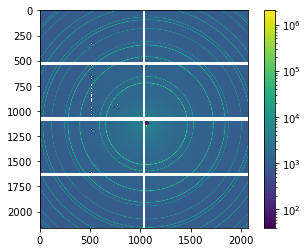

In [3]:
# load and display a demo image
img = h5py.File(h5name,'r')['1.1/measurement/eiger'][1]
msk = img < 1e8

pl.figure()
pl.imshow( img * msk, norm = LogNorm() )
pl.colorbar()

Geometric description of the Eiger4M modules:

In [4]:
# Geometry of the modules
# fast = 0 - 512
# slow = 0 - 511
# 4x4 grid of these
def mod_start(s,f):
    """ s, f are the module coordinates in the range 0-4
    s/f refer to fast/slow pixel directions to use in C style
    array indexing data[s][f].
    returns the first pixel in the corner of the module
    """
    fsize = 513
    ssize = 512
    foffset = [ 0,  2,   14,   16]
    soffset = [ 0, 38, 2*38, 38*3]
    fstart = fsize*f + foffset[f]
    sstart = ssize*s + soffset[s]
    return sstart, fstart

def module(image, s, f):
    """ image is a full Eiger4M image.
    s,f selects one of the 4x4 modules 
    pad (for debugging) adds a border around the module
    """
    #p = padding around the outside for debug
    fsize = 513
    ssize = 512
    foffset = [0,  2,   14,   16]
    soffset = [0, 38, 2*38, 38*3]
    fstart = fsize*f + foffset[f]
    sstart = ssize*s + soffset[s]
    roi = image[ sstart : sstart + ssize,
                 fstart : fstart + fsize]
    return roi

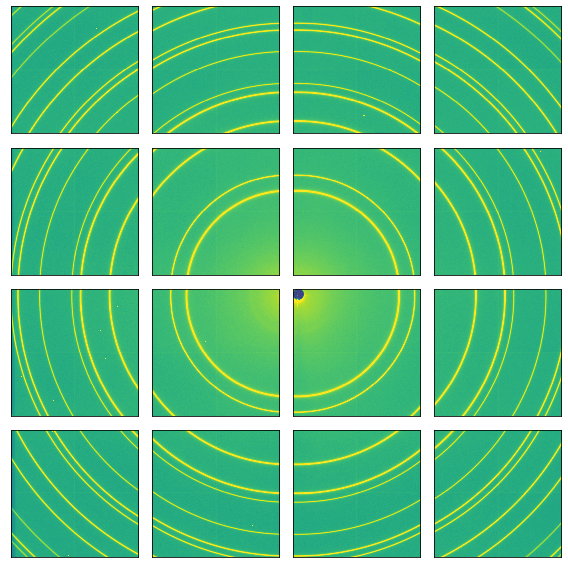

In [5]:
# check we have the module geometry
fig, ax = pl.subplots( 4, 4, figsize=(8,8))
for s in range(4):
    for f in range(4):
        ax[s][f].imshow( module(img,s,f), norm=pl.matplotlib.colors.LogNorm(20,10000))
        ax[s][f].set(xticks=[], yticks=[])
fig.tight_layout()

(0, 5000)

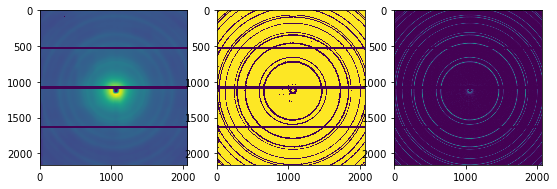

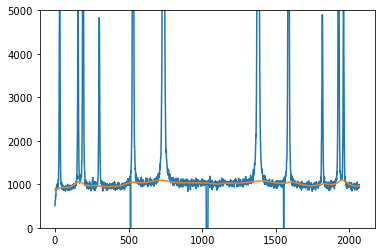

In [6]:
# Estimate what is peak and background
def guessbg( img, nsigma = 5, size = 64, cycles = 5, saturated=pow(2,31)):
    msk = ( img < saturated ) & ( img > 0 )
    sigdata = np.sqrt(img) # approximation
    for i in range(3):
        cimg  = img.astype(np.float32) * msk
        sumpx = ndi.uniform_filter( cimg, size=size, mode='constant', cval=0 )
        sum1  = ndi.uniform_filter( msk.astype(np.float32),  size=size, mode='constant' )
        avg   = sumpx / np.where(sum1>0, sum1, 1)
        pks   = cimg > avg + sigdata * nsigma
        msk   = msk & (~pks)
    cimg = img.astype(np.float32) * msk
    sumpx = ndi.uniform_filter( cimg, size=size, mode='constant' )
    sum1  = ndi.uniform_filter( msk.astype(np.float32), size=size, mode='constant' )
    avg   = sumpx / np.where(sum1>0, sum1, 1)
    return avg, msk

bkgimage, bgmask = guessbg( img )
msk = img < 4e9
bim = (img.astype(np.float32) - bkgimage)*msk

fig, ax = pl.subplots(1, 3, figsize=(9,3))
ax[0].imshow( bkgimage * msk )
ax[1].imshow( bgmask )
ax[2].imshow( bim + 1000, norm=LogNorm(vmin=1000) )
pl.figure()
pl.plot((img*msk)[10])
pl.plot(bkgimage[10])
pl.ylim(0,5000)

We will go through the modules one by one and look for peaks in each row and column of pixels. 

In [7]:
@numba.njit
def fitpks(signal, msk, mbg, bgv, minpk=4, maxpk=35, label = 0):
    """ 
    signal is a 2D array with peaks in it
    msk defines which pixels can be used (skip values > 1e9)
    mbg labels pixels as being part of peak or background
    bgv estimate of the background level
    minpk = 4  : number of pixels needed to define a peak
    maxpk = 35 : max number of pixels allowed in a peak
    label = int : to track where peaks came from
    
    condition is finding bg->pk->bg with (maxpk > s1 > minpk) 
    
    The +1 is due to the clipping before calling this function (???)
    
    returns a list of peaks, each peak is:
      (slow_center, fast_center, sum_signal, npixels, fixed_index, module_label)
    """
    pks=[]
    for i in range(signal.shape[0]):
        s1 = 0       # sum of pixels in peak
        sI = 0       # sum of intensity in peak
        sfI = 0      # sum of intensity * fast pixel co-ordindate
        gotbg = False
        for j in range(signal.shape[1]):
            if msk[i,j] == 1: # pixels can be used
                if mbg[i,j] == 1: # in background
                    gotbg = True
                    # save the last peak if there was one
                    if s1 > minpk and s1 < maxpk:
                        # centre of mass position is sfI/sI
                        pks.append( (i , float(sfI) / sI , sI, s1, 0, label ) )
                    # ... and reset peak counters
                    s1 = 0; sI = 0; sfI = 0
                else: # inside a peak
                    if gotbg:
                        s1  += 1; 
                        sI  += (signal[i,j]-bgv)
                        sfI += (signal[i,j]-bgv)*j
            else: # just saw mask, so reset sums
                s1  = 0
                sfI = 0
                sI  = 0
                gotbg = False
    # Now repeat the same code but for the transposed array
    for j in range(signal.shape[1]):
        s1 = 0
        sI = 0
        ssI = 0
        gotbg = False
        for i in range(signal.shape[0]):
            if msk[i,j] == 1: # pixels can be used
                if mbg[i,j] == 1: # in background
                    gotbg = True
                    if s1 >= minpk and s1 < maxpk:
                        pks.append( ( float(ssI) / sI , j , sI, s1, 1, label))
                    s1 = 0; sI = 0; ssI = 0
                else: # in peak
                    if gotbg:
                        s1  += 1
                        sI  += (signal[i,j]-bgv) 
                        ssI += (signal[i,j]-bgv)*i
            else:
                s1 = 0
                ssI = 0
                sI = 0
    if len(pks) == 0:
        return None
    else:
        return np.array(pks)

def process_chip(chip, plt=0, modu=0, nsigma=3):
    """ chip = 2D array
    
    plt > 0 : plot spot positions
    plt < 0 : show segmentation and peak positions
    
    modu = module label
    
    Defines a mask
    Thresholds to determine what is peak versus background
    Runs fitpks to get peak positions
    return peak positions
    """
    roi = chip.copy()
    msk = roi < 4e9    # Dectris mask
    roi = roi * msk    # zeros out the bad pixels
    sel = msk          # select all pixels as background
    for i in range(5):
        m = roi[sel].mean()   # mean background value
        s = roi[sel].std()    # sigma - clipping method (from pyFAI / vamvakeros / et al)
        sel = (roi < m+s*nsigma) & msk
    bg1 = roi[sel].mean()    
    mbg = sel
    pks = fitpks( roi, msk, mbg, bg1, minpk=3, label=modu )
    return pks, mbg

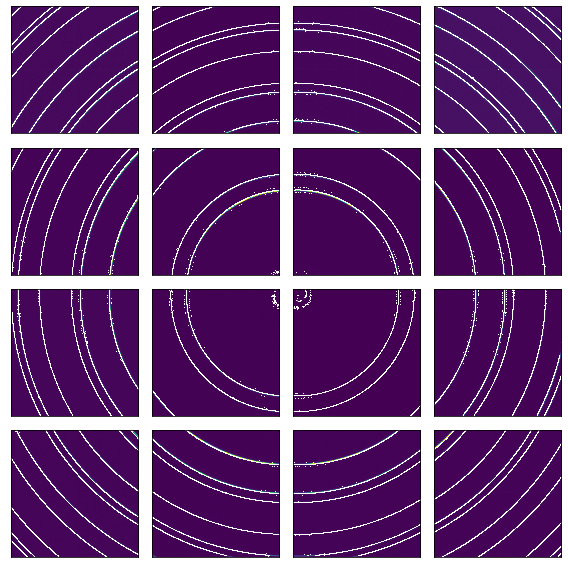

In [8]:
# test with plot
fig, ax = pl.subplots(4, 4, figsize=(8,8))
for i in range(4):
    for j in range(4):
        roi = module(bim,i,j)
        pks, mbg = process_chip(roi, plt=i*4+j+1, modu=i*4+i)
        ax[i][j].imshow( roi )
        ax[i][j].plot( pks[:,1], pks[:,0], "w," )
        ax[i][j].set(xticks=[], yticks=[])
fig.tight_layout()

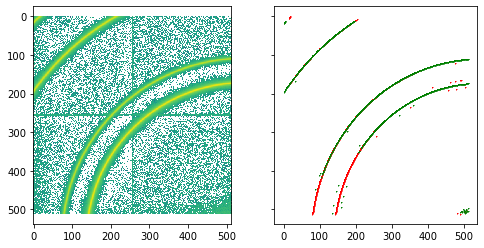

In [9]:
fig, ax = pl.subplots(1,2, sharey=True, figsize=(8,4))
roi = module(bim,1,1)
ax[0].imshow(roi, norm=LogNorm(vmax=200000),aspect='equal')
pks, mbg = process_chip(module(bim,1,1), plt=-1)
s=pks[:,4]==0
ax[1].plot( pks[s,1],pks[s,0], "r+", ms=1)
ax[1].plot( pks[~s,1],pks[~s,0], "g+", ms=1)

In [10]:
def search_image(im):
    """Loops over the 4x4 modules"""
    allpks = []
    bkgimage, bgmask = guessbg( im )
    msk = im < 4e9
    bim = (im.astype(np.float32) - bkgimage)*msk
    for i in range(4):
        for j in range(4):
            cs = module(bim,i,j)
            pks, mbg = process_chip(cs, modu=i*4+j)
            io, jo = mod_start(i,j)
            if pks is not None:
                pks[:,0] += io
                pks[:,1] += jo
                allpks.append(pks)
    ap = np.concatenate(allpks,axis=0).T
    return ap

In [11]:
%%time
p = search_image(img)
print(p.shape)

(6, 52659)
CPU times: user 544 ms, sys: 71.4 ms, total: 615 ms
Wall time: 683 ms


(6, 52659)


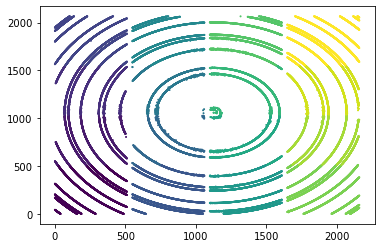

In [12]:
sc,fc,sI,s1,sf,m = p = search_image(img)
pl.figure()
pl.scatter(sc,fc,c=m,s=1)
print(p.shape)

In [13]:
def saveflt(outname, pks):
    """Save the peaks into ImageD11 columnfile format (text file)"""
    with open(outname,"w") as f:
        f.write("#  sc  fc  omega  Number_of_pixels  sum_intensity  direction  module  s_raw  f_raw\n")
        for sc,fc,I,s1,sf,m in pks.T:
            f.write("%.3f %.3f 0.0 %d %.1f %d %d %.3f %.3f\n"%(sc,fc,s1,I,sf,m,sc,fc))
saveflt("demo.flt", p) 

In [14]:
!pwd
if not os.path.exists("eigerSpatial"):
    os.mkdir("eigerSpatial")

/home/esrf/wright/git/EigerPowderSpatial


In [15]:
# Now search all the images and save the output
with h5py.File(h5name,'r') as h:
    for scan in list(h['/']):
        if scan.endswith(".1") and 'eiger' in h[scan]['measurement']:
            frms = h[scan]['measurement/eiger']
            print(scan,frms.shape,np.median(frms[1,:256,:256]))
            im = frms[:].sum(axis=0)
            pks = search_image( im )
            outname = "eigerSpatial/%s.flt"%(scan.split('.')[0])
            saveflt(outname, pks) 

1.1 (2, 2162, 2068) 936.0
2.1 (2, 2162, 2068) 791.0
3.1 (2, 2162, 2068) 763.0
4.1 (2, 2162, 2068) 899.0


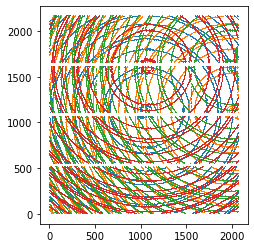

In [16]:
from ImageD11.columnfile import columnfile
import glob
pl.figure()
for fname in sorted(glob.glob("eigerSpatial/*.flt")):
    c = columnfile( fname )
    pl.plot(c.fc,c.sc,',')
pl.gca().set_aspect('equal')

In [17]:
print("Output created on %s"%(time.ctime()))
print("Total runtime %.3f /s"%(time.time()-start))

Output created on Mon Dec  6 09:00:35 2021
Total runtime 10.465 /s
